# Indoor Positioning System (IPS) menggunakan WiFi Fingerprinting
## Prediksi Koordinat Posisi berdasarkan Sinyal WiFi UNTIRTA

Notebook ini akan membangun Indoor Positioning System menggunakan pendekatan WiFi fingerprinting. Berbeda dengan simple location classification, IPS bertujuan untuk memprediksi koordinat posisi yang presisi (latitude, longitude) berdasarkan pola sinyal WiFi yang terdeteksi.

### Konsep WiFi Fingerprinting untuk IPS:
1. **Training Phase**: Mengumpulkan "fingerprint" sinyal WiFi di berbagai posisi yang diketahui
2. **Positioning Phase**: Mencocokkan sinyal yang terdeteksi dengan database fingerprint untuk estimasi posisi
3. **Output**: Koordinat posisi (latitude, longitude) bukan hanya nama lokasi

## 1. Import Libraries dan Setup Environment

In [1]:
# Import libraries yang diperlukan untuk IPS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial import distance
import warnings
warnings.filterwarnings('ignore')

# Setup untuk visualisasi yang lebih baik
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Fungsi helper untuk menghitung error dalam meter
def calculate_distance_error(y_true, y_pred, scale_factor=111000):
    """
    Menghitung error jarak dalam meter antara posisi sebenarnya dan prediksi.
    scale_factor: konversi derajat ke meter (approx 111km per derajat)
    """
    errors = []
    for i in range(len(y_true)):
        # Hitung jarak Euclidean
        lat_error = (y_true[i][0] - y_pred[i][0]) * scale_factor
        lon_error = (y_true[i][1] - y_pred[i][1]) * scale_factor
        error_meters = np.sqrt(lat_error**2 + lon_error**2)
        errors.append(error_meters)
    return np.array(errors)

## 2. Load dan Eksplorasi Data untuk IPS

In [2]:
# Load data WiFi scanning
df = pd.read_csv('wifi_scan_20250613_Fisip.csv')

# Informasi dasar dataset
print(f"Ukuran dataset: {df.shape}")
print(f"\nKolom yang tersedia:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")

# Cek range koordinat untuk memahami area coverage
print(f"\nRange Latitude: {df['Latitude'].min():.6f} to {df['Latitude'].max():.6f}")
print(f"Range Longitude: {df['Longitude'].min():.6f} to {df['Longitude'].max():.6f}")

# Estimasi ukuran area dalam meter
lat_range_m = (df['Latitude'].max() - df['Latitude'].min()) * 111000
lon_range_m = (df['Longitude'].max() - df['Longitude'].min()) * 111000
print(f"\nEstimasi ukuran area:")
print(f"- Latitude range: ~{lat_range_m:.1f} meter")
print(f"- Longitude range: ~{lon_range_m:.1f} meter")

Ukuran dataset: (528, 19)

Kolom yang tersedia:
- Location Name: object
- Timestamp: object
- Latitude: float64
- Longitude: float64
- SSID: object
- BSSID: object
- Signal Strength (%): int64
- Signal Strength (dBm): float64
- Network Type: float64
- Radio Type: object
- Channel: int64
- Band: object
- Authentication: float64
- Encryption: float64
- Connected Stations: float64
- Channel Utilization: float64
- Medium Available Capacity: float64
- Basic Rates: object
- Other Rates: object

Range Latitude: -6.190700 to -6.190496
Range Longitude: 106.124063 to 106.124404

Estimasi ukuran area:
- Latitude range: ~22.6 meter
- Longitude range: ~37.9 meter


In [3]:
# Filter hanya data UNTIRTA untuk fokus pada network yang konsisten
df_untirta = df[df['SSID'] == 'UNTIRTA'].copy()
print(f"Total data UNTIRTA: {len(df_untirta)} dari {len(df)} ({len(df_untirta)/len(df)*100:.1f}%)")

# Analisis temporal - berapa scanning session yang ada
unique_timestamps = df_untirta['Timestamp'].unique()
print(f"\nJumlah timestamp unik (scanning sessions): {len(unique_timestamps)}")

# Analisis posisi unik berdasarkan koordinat
unique_positions = df_untirta[['Latitude', 'Longitude']].drop_duplicates()
print(f"Jumlah posisi unik dalam dataset: {len(unique_positions)}")

# Tampilkan contoh data
print("\nContoh data (5 baris pertama):")
df_untirta.head()

Total data UNTIRTA: 407 dari 528 (77.1%)

Jumlah timestamp unik (scanning sessions): 35
Jumlah posisi unik dalam dataset: 26

Contoh data (5 baris pertama):


,Location Name,Timestamp,Latitude,Longitude,SSID,BSSID,Signal Strength (%),Signal Strength (dBm),Network Type,Radio Type,Channel,Band,Authentication,Encryption,Connected Stations,Channel Utilization,Medium Available Capacity,Basic Rates,Other Rates
0,FISIP_LOBBY_LT1_1,2025-06-13 14:36:40,-6.190504,106.124284,UNTIRTA,06:0d:9e:25:7b:32,24,-75.6,NaN,802.11ac,149,5 GHz,NaN,NaN,NaN,NaN,NaN,6 12 24,9 18 36 48 54
1,FISIP_LOBBY_LT1_1,2025-06-13 14:36:40,-6.190504,106.124284,UNTIRTA,06:70:ab:a7:ab:7b,24,-75.6,NaN,802.11ac,157,5 GHz,NaN,NaN,NaN,NaN,NaN,6 12 24,9 18 36 48 54
2,FISIP_LOBBY_LT1_1,2025-06-13 14:36:40,-6.190504,106.124284,UNTIRTA,06:0d:9e:a8:8a:90,62,-52.8,NaN,802.11n,1,2.4 GHz,NaN,NaN,NaN,NaN,NaN,11,6 9 12 18 24 36 48 54
3,FISIP_LOBBY_LT1_1,2025-06-13 14:36:40,-6.190504,106.124284,UNTIRTA,06:0d:9e:a8:88:78,46,-62.4,NaN,802.11n,1,2.4 GHz,NaN,NaN,NaN,NaN,NaN,1 2 5.5 11,6 9 12 18 24 36 48 54
4,FISIP_LOBBY_LT1_1,2025-06-13 14:36:40,-6.190504,106.124284,UNTIRTA,06:5d:54:90:dc:e2,53,-58.2,NaN,802.11n,1,2.4 GHz,NaN,NaN,NaN,NaN,NaN,11,6 9 12 18 24 36 48 54


## 3. Visualisasi Spatial Distribution untuk IPS

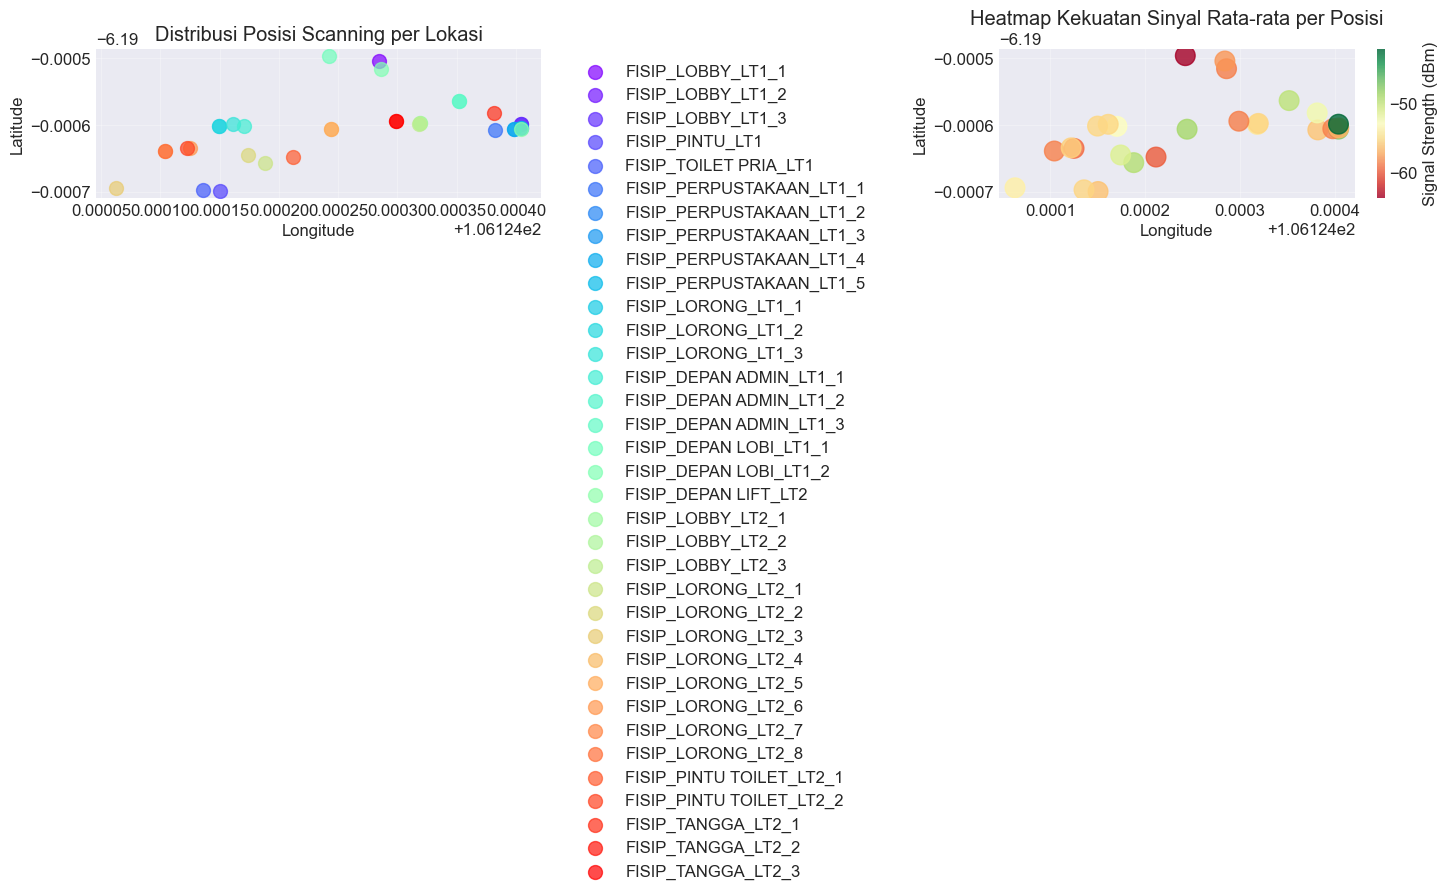

In [4]:
# Visualisasi distribusi posisi scanning
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot posisi dengan color berdasarkan lokasi
locations = df_untirta['Location Name'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(locations)))

for loc, color in zip(locations, colors):
    loc_data = df_untirta[df_untirta['Location Name'] == loc]
    positions = loc_data[['Latitude', 'Longitude']].drop_duplicates()
    ax1.scatter(positions['Longitude'], positions['Latitude'], 
                label=loc, alpha=0.7, s=100, c=[color])

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Distribusi Posisi Scanning per Lokasi')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Heatmap kekuatan sinyal rata-rata per posisi
avg_signal_per_position = df_untirta.groupby(['Latitude', 'Longitude'])['Signal Strength (dBm)'].mean().reset_index()
scatter = ax2.scatter(avg_signal_per_position['Longitude'], 
                      avg_signal_per_position['Latitude'],
                      c=avg_signal_per_position['Signal Strength (dBm)'],
                      cmap='RdYlGn', s=200, alpha=0.8)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Heatmap Kekuatan Sinyal Rata-rata per Posisi')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Signal Strength (dBm)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing untuk WiFi Fingerprinting

In [5]:
# Membuat fingerprint database
# Setiap fingerprint adalah kombinasi posisi-timestamp dengan semua BSSID yang terdeteksi

# Group by position dan timestamp untuk membuat fingerprint
fingerprints = df_untirta.pivot_table(
    index=['Latitude', 'Longitude', 'Location Name', 'Timestamp'],
    columns='BSSID',
    values='Signal Strength (dBm)',
    aggfunc='mean'  # Jika ada duplicate, ambil rata-rata
).reset_index()

print(f"Jumlah fingerprint: {len(fingerprints)}")
print(f"Jumlah BSSID unik: {len(fingerprints.columns) - 4}")

# Analisis missing values (BSSID tidak terdeteksi)
bssid_columns = [col for col in fingerprints.columns if col not in ['Latitude', 'Longitude', 'Location Name', 'Timestamp']]
missing_percentage = (fingerprints[bssid_columns].isna().sum() / len(fingerprints) * 100).sort_values(ascending=False)

print(f"\nStatistik Missing Values (BSSID tidak terdeteksi):")
print(f"- Rata-rata: {missing_percentage.mean():.1f}%")
print(f"- Minimum: {missing_percentage.min():.1f}%")
print(f"- Maximum: {missing_percentage.max():.1f}%")

Jumlah fingerprint: 35
Jumlah BSSID unik: 52

Statistik Missing Values (BSSID tidak terdeteksi):
- Rata-rata: 77.6%
- Minimum: 28.6%
- Maximum: 97.1%


In [6]:
# Strategi handling missing values untuk IPS
# Untuk WiFi fingerprinting, nilai missing sangat informatif (berarti sinyal tidak terdeteksi)

# Opsi 1: Isi dengan nilai minimum - threshold (menandakan sinyal sangat lemah)
min_signal = df_untirta['Signal Strength (dBm)'].min()
threshold_value = min_signal - 10  # -10 dBm dari sinyal terlemah

# Opsi 2: Isi dengan nilai yang menandakan "tidak terdeteksi" 
no_signal_value = -100  # Nilai standar untuk "no signal"

# Kita akan gunakan opsi 2 untuk IPS
print(f"Nilai untuk BSSID tidak terdeteksi: {no_signal_value} dBm")

# Fill missing values
fingerprints_filled = fingerprints.copy()
fingerprints_filled[bssid_columns] = fingerprints_filled[bssid_columns].fillna(no_signal_value)

# Verifikasi tidak ada missing values
print(f"\nMissing values setelah preprocessing: {fingerprints_filled[bssid_columns].isna().sum().sum()}")

Nilai untuk BSSID tidak terdeteksi: -100 dBm

Missing values setelah preprocessing: 0


## 5. Feature Engineering untuk Indoor Positioning

In [7]:
# Ekstrak features dan target untuk IPS
# Features: Signal strength dari semua BSSID
# Target: Koordinat (Latitude, Longitude)

X = fingerprints_filled[bssid_columns].values
y = fingerprints_filled[['Latitude', 'Longitude']].values

print(f"Shape of features (X): {X.shape}")
print(f"Shape of targets (y): {y.shape}")
print(f"\nJumlah fingerprint: {X.shape[0]}")
print(f"Jumlah features (BSSID): {X.shape[1]}")

# Analisis variabilitas signal strength per BSSID
signal_std = fingerprints_filled[bssid_columns].std()
high_variance_bssids = signal_std[signal_std > 5].sort_values(ascending=False)

print(f"\nBSSID dengan variabilitas tinggi (std > 5 dBm): {len(high_variance_bssids)}")
print("Top 10 BSSID dengan variabilitas tertinggi:")
for bssid, std in high_variance_bssids.head(10).items():
    print(f"- {bssid}: std = {std:.2f} dBm")

Shape of features (X): (35, 52)
Shape of targets (y): (35, 2)

Jumlah fingerprint: 35
Jumlah features (BSSID): 52

BSSID dengan variabilitas tinggi (std > 5 dBm): 47
Top 10 BSSID dengan variabilitas tertinggi:
- 06:0d:9e:a8:8a:9c: std = 30.29 dBm
- 06:0d:9e:a8:8a:6c: std = 29.51 dBm
- 06:0d:9e:a8:8a:dd: std = 28.90 dBm
- 06:0d:9e:a8:8a:6d: std = 28.86 dBm
- 06:0d:9e:a8:84:79: std = 28.76 dBm
- 06:0d:9e:a8:8a:dc: std = 28.47 dBm
- 06:70:ab:a7:ab:76: std = 27.36 dBm
- 06:0d:9e:a8:84:78: std = 27.32 dBm
- 06:0d:9e:a8:8a:90: std = 27.31 dBm
- 06:0d:9e:a8:8a:91: std = 25.87 dBm


In [8]:
# Feature selection berdasarkan coverage dan variability
# Untuk IPS, kita ingin BSSID yang:
# 1. Memiliki coverage yang baik (tidak terlalu banyak missing)
# 2. Memiliki variabilitas yang cukup (informatif untuk positioning)

# Hitung detection rate per BSSID
detection_rate = (fingerprints[bssid_columns] != no_signal_value).sum() / len(fingerprints)

# Filter BSSID dengan detection rate > 10%
min_detection_rate = 0.1
selected_bssids = detection_rate[detection_rate > min_detection_rate].index.tolist()

print(f"BSSID yang dipilih (detection rate > {min_detection_rate*100}%): {len(selected_bssids)} dari {len(bssid_columns)}")

# Update features dengan BSSID terpilih
X_selected = fingerprints_filled[selected_bssids].values
print(f"\nShape features setelah selection: {X_selected.shape}")

BSSID yang dipilih (detection rate > 10.0%): 52 dari 52

Shape features setelah selection: (35, 52)


## 6. Data Splitting dan Normalization untuk IPS

Training set: 28 fingerprints
Test set: 7 fingerprints


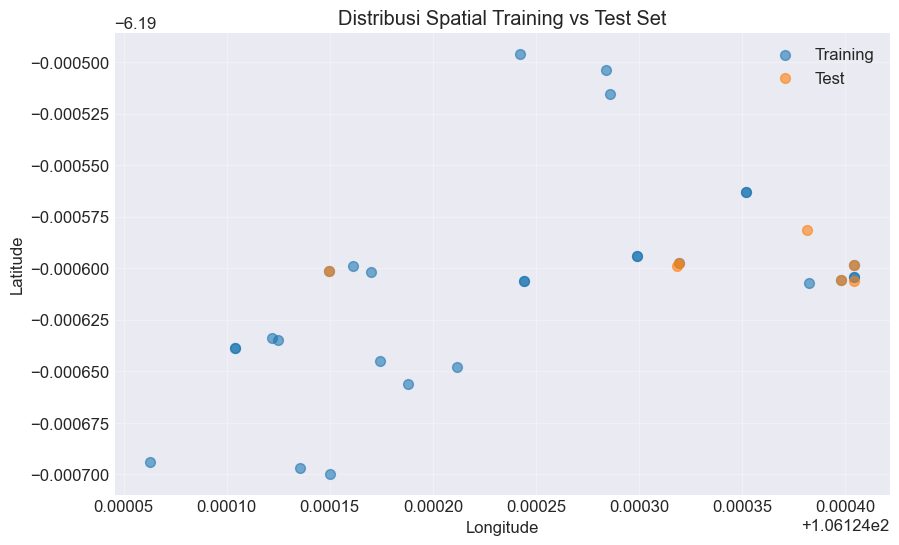

In [9]:
# Split data dengan strategi yang sesuai untuk IPS
# Kita ingin memastikan distribusi spatial yang baik di train dan test set

# Random split dengan seed untuk reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} fingerprints")
print(f"Test set: {X_test.shape[0]} fingerprints")

# Visualisasi distribusi train/test
plt.figure(figsize=(10, 6))
plt.scatter(y_train[:, 1], y_train[:, 0], alpha=0.6, label='Training', s=50)
plt.scatter(y_test[:, 1], y_test[:, 0], alpha=0.6, label='Test', s=50)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribusi Spatial Training vs Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Normalisasi features untuk model yang sensitive terhadap scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Statistik setelah normalisasi:")
print(f"Mean: {X_train_scaled.mean():.4f}")
print(f"Std: {X_train_scaled.std():.4f}")
print(f"Min: {X_train_scaled.min():.4f}")
print(f"Max: {X_train_scaled.max():.4f}")

Statistik setelah normalisasi:
Mean: -0.0000
Std: 1.0000
Min: -1.2789
Max: 5.1962


## 7. Model Development untuk Indoor Positioning

Untuk IPS, kita akan menggunakan regression models yang dapat memprediksi koordinat kontinyu.

### 7.1 K-Nearest Neighbors Regression (Weighted KNN)

K=3: Mean positioning error = 2.24 meters
K=5: Mean positioning error = 2.30 meters
K=7: Mean positioning error = 2.02 meters
K=10: Mean positioning error = 2.51 meters
K=15: Mean positioning error = 4.96 meters
K=20: Mean positioning error = 6.82 meters
K=25: Mean positioning error = 7.56 meters


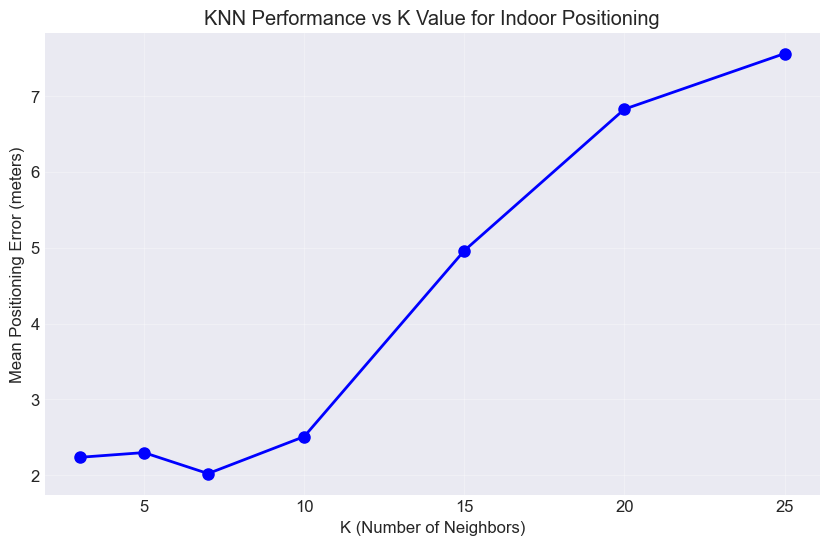


Optimal K: 7 dengan error: 2.02 meters


In [11]:
# KNN adalah metode populer untuk WiFi fingerprinting karena konsep similarity
# Kita akan menggunakan weighted KNN dimana neighbor terdekat memiliki pengaruh lebih besar

# Optimasi parameter K
max_k = len(X_train_scaled)
k_values = [k for k in [3, 5, 7, 10, 15, 20, 25, 30] if k <= max_k]
knn_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    
    # Hitung error dalam meter
    errors = calculate_distance_error(y_test, y_pred)
    mean_error = errors.mean()
    knn_scores.append(mean_error)
    print(f"K={k}: Mean positioning error = {mean_error:.2f} meters")

# Plot hasil optimasi
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Mean Positioning Error (meters)')
plt.title('KNN Performance vs K Value for Indoor Positioning')
plt.grid(True, alpha=0.3)
plt.show()

# Gunakan K optimal
optimal_k = k_values[np.argmin(knn_scores)]
print(f"\nOptimal K: {optimal_k} dengan error: {min(knn_scores):.2f} meters")

In [12]:
# Train final KNN model dengan parameter optimal
knn_model = KNeighborsRegressor(
    n_neighbors=optimal_k,
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluasi detail
knn_errors = calculate_distance_error(y_test, y_pred_knn)
print("KNN Regression Performance:")
print(f"- Mean positioning error: {knn_errors.mean():.2f} meters")
print(f"- Median positioning error: {np.median(knn_errors):.2f} meters")
print(f"- 90th percentile error: {np.percentile(knn_errors, 90):.2f} meters")
print(f"- Maximum error: {knn_errors.max():.2f} meters")

KNN Regression Performance:
- Mean positioning error: 2.02 meters
- Median positioning error: 1.46 meters
- 90th percentile error: 4.29 meters
- Maximum error: 5.35 meters


### 7.2 Random Forest Regression

In [13]:
# Random Forest untuk multi-output regression
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Training
rf_model.fit(X_train, y_train)  # RF tidak memerlukan scaling
y_pred_rf = rf_model.predict(X_test)

# Evaluasi
rf_errors = calculate_distance_error(y_test, y_pred_rf)
print("Random Forest Regression Performance:")
print(f"- Mean positioning error: {rf_errors.mean():.2f} meters")
print(f"- Median positioning error: {np.median(rf_errors):.2f} meters")
print(f"- 90th percentile error: {np.percentile(rf_errors, 90):.2f} meters")
print(f"- Maximum error: {rf_errors.max():.2f} meters")

# Feature importance untuk IPS
feature_importance = pd.DataFrame({
    'bssid': selected_bssids,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important BSSID untuk positioning:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"- {row['bssid']}: {row['importance']:.4f}")

Random Forest Regression Performance:
- Mean positioning error: 7.40 meters
- Median positioning error: 7.82 meters
- 90th percentile error: 8.75 meters
- Maximum error: 8.81 meters

Top 10 most important BSSID untuk positioning:
- 06:70:ab:a7:ab:77: 0.1900
- 06:0d:9e:a8:89:51: 0.0693
- 06:5d:54:90:dc:e2: 0.0677
- 06:0d:9e:a8:8a:9c: 0.0473
- 06:70:ab:a7:ab:76: 0.0464
- 06:5d:54:90:dc:e3: 0.0460
- 06:0d:9e:25:76:86: 0.0452
- 06:0d:9e:a8:89:58: 0.0432
- 06:0d:9e:a8:8a:dc: 0.0413
- 06:0d:9e:a8:84:78: 0.0380


### 7.3 Support Vector Regression (SVR)

In [14]:
# SVR dengan MultiOutputRegressor untuk prediksi latitude dan longitude
from sklearn.multioutput import MultiOutputRegressor

# Base SVR model
base_svr = SVR(
    kernel='rbf',
    C=10,
    gamma='scale',
    epsilon=0.1
)

# Wrap dengan MultiOutputRegressor
svr_model = MultiOutputRegressor(base_svr, n_jobs=-1)

# Training dengan scaled data
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluasi
svr_errors = calculate_distance_error(y_test, y_pred_svr)
print("SVR Performance:")
print(f"- Mean positioning error: {svr_errors.mean():.2f} meters")
print(f"- Median positioning error: {np.median(svr_errors):.2f} meters")
print(f"- 90th percentile error: {np.percentile(svr_errors, 90):.2f} meters")
print(f"- Maximum error: {svr_errors.max():.2f} meters")

SVR Performance:
- Mean positioning error: 14.42 meters
- Median positioning error: 16.53 meters
- 90th percentile error: 18.93 meters
- Maximum error: 18.94 meters


### 7.4 Gradient Boosting Regression

In [15]:
# Gradient Boosting untuk IPS
# Kita akan train model terpisah untuk latitude dan longitude

gb_lat = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_lon = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Training
gb_lat.fit(X_train, y_train[:, 0])  # Latitude
gb_lon.fit(X_train, y_train[:, 1])  # Longitude

# Predictions
y_pred_gb_lat = gb_lat.predict(X_test)
y_pred_gb_lon = gb_lon.predict(X_test)
y_pred_gb = np.column_stack([y_pred_gb_lat, y_pred_gb_lon])

# Evaluasi
gb_errors = calculate_distance_error(y_test, y_pred_gb)
print("Gradient Boosting Performance:")
print(f"- Mean positioning error: {gb_errors.mean():.2f} meters")
print(f"- Median positioning error: {np.median(gb_errors):.2f} meters")
print(f"- 90th percentile error: {np.percentile(gb_errors, 90):.2f} meters")
print(f"- Maximum error: {gb_errors.max():.2f} meters")

Gradient Boosting Performance:
- Mean positioning error: 2.37 meters
- Median positioning error: 0.05 meters
- 90th percentile error: 7.18 meters
- Maximum error: 10.61 meters


## 8. Model Comparison dan Evaluation untuk IPS

Model Performance Comparison for Indoor Positioning:
               Model  Mean Error (m)  Median Error (m)  Std Error (m)  \
0                KNN            2.02              1.46           1.88   
1      Random Forest            7.40              7.82           1.73   
2                SVR           14.42             16.53           4.39   
3  Gradient Boosting            2.37              0.05           3.75   

   90% Error (m)  Max Error (m)  
0           4.29           5.35  
1           8.75           8.81  
2          18.93          18.94  
3           7.18          10.61  


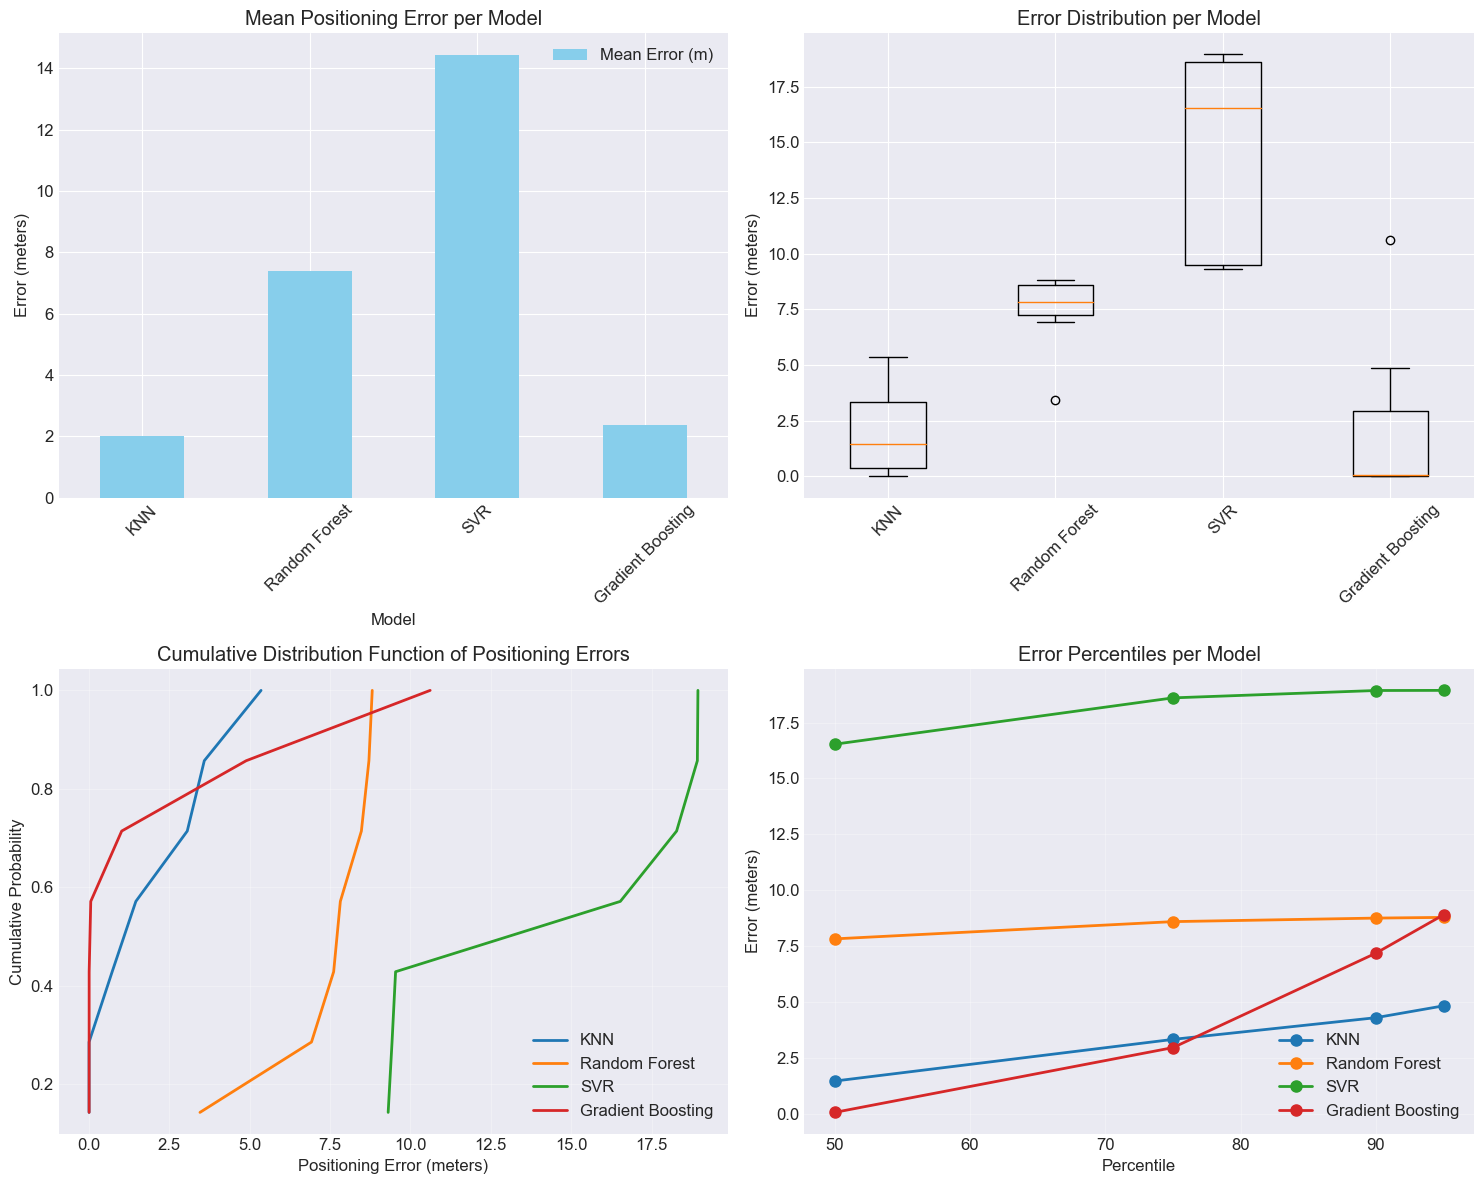

In [16]:
# Kompilasi hasil semua model
models_errors = {
    'KNN': knn_errors,
    'Random Forest': rf_errors,
    'SVR': svr_errors,
    'Gradient Boosting': gb_errors
}

# Statistik perbandingan
comparison_df = pd.DataFrame({
    'Model': models_errors.keys(),
    'Mean Error (m)': [errors.mean() for errors in models_errors.values()],
    'Median Error (m)': [np.median(errors) for errors in models_errors.values()],
    'Std Error (m)': [errors.std() for errors in models_errors.values()],
    '90% Error (m)': [np.percentile(errors, 90) for errors in models_errors.values()],
    'Max Error (m)': [errors.max() for errors in models_errors.values()]
})

print("Model Performance Comparison for Indoor Positioning:")
print(comparison_df.round(2))

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Bar chart mean errors
ax1 = axes[0, 0]
comparison_df.plot(x='Model', y='Mean Error (m)', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Mean Positioning Error per Model')
ax1.set_ylabel('Error (meters)')
ax1.set_xticklabels(comparison_df['Model'], rotation=45)

# Plot 2: Box plot error distributions
ax2 = axes[0, 1]
error_data = [errors for errors in models_errors.values()]
ax2.boxplot(error_data, labels=models_errors.keys())
ax2.set_title('Error Distribution per Model')
ax2.set_ylabel('Error (meters)')
ax2.set_xticklabels(models_errors.keys(), rotation=45)

# Plot 3: CDF of errors
ax3 = axes[1, 0]
for model_name, errors in models_errors.items():
    sorted_errors = np.sort(errors)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax3.plot(sorted_errors, cdf, label=model_name, linewidth=2)
ax3.set_xlabel('Positioning Error (meters)')
ax3.set_ylabel('Cumulative Probability')
ax3.set_title('Cumulative Distribution Function of Positioning Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Error percentiles
ax4 = axes[1, 1]
percentiles = [50, 75, 90, 95]
for model_name, errors in models_errors.items():
    percentile_values = [np.percentile(errors, p) for p in percentiles]
    ax4.plot(percentiles, percentile_values, 'o-', label=model_name, linewidth=2, markersize=8)
ax4.set_xlabel('Percentile')
ax4.set_ylabel('Error (meters)')
ax4.set_title('Error Percentiles per Model')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Spatial Error Analysis

Model terbaik: KNN


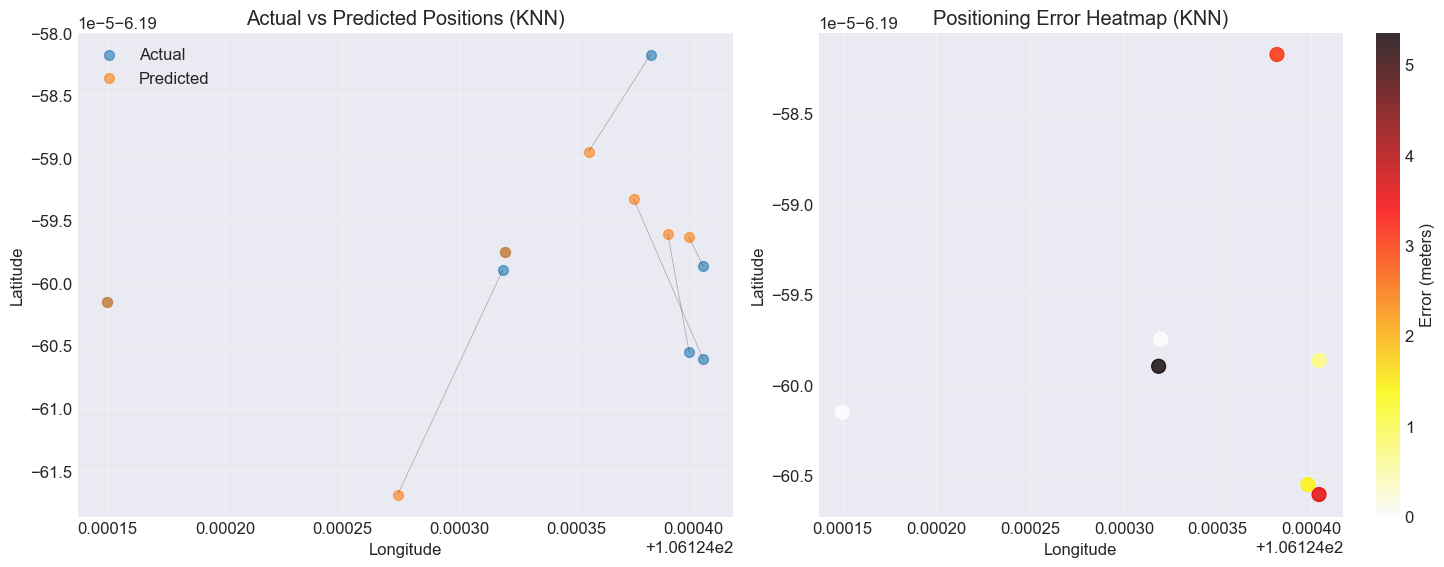


Average positioning error per location:
                          mean  std  count
Location                                  
FISIP_DEPAN LIFT_LT2      3.58  NaN      1
FISIP_LOBBY_LT1_2         0.72  NaN      1
FISIP_LOBBY_LT2_1         0.00  NaN      1
FISIP_LOBBY_LT2_3         5.35  NaN      1
FISIP_LORONG_LT1_1        0.00  NaN      1
FISIP_PERPUSTAKAAN_LT1_3  1.46  NaN      1
FISIP_TANGGA_LT2_1        3.05  NaN      1


In [17]:
# Analisis spatial dari error untuk model terbaik
best_model_errors = min(models_errors.items(), key=lambda x: x[1].mean())
best_model_name = best_model_errors[0]
print(f"Model terbaik: {best_model_name}")

# Get predictions dari model terbaik
if best_model_name == 'KNN':
    best_predictions = y_pred_knn
elif best_model_name == 'Random Forest':
    best_predictions = y_pred_rf
elif best_model_name == 'SVR':
    best_predictions = y_pred_svr
else:
    best_predictions = y_pred_gb

# Visualisasi error spatial
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Actual vs Predicted positions
ax1.scatter(y_test[:, 1], y_test[:, 0], alpha=0.6, label='Actual', s=50)
ax1.scatter(best_predictions[:, 1], best_predictions[:, 0], alpha=0.6, label='Predicted', s=50)

# Draw lines between actual and predicted
for i in range(len(y_test)):
    ax1.plot([y_test[i, 1], best_predictions[i, 1]], 
             [y_test[i, 0], best_predictions[i, 0]], 
             'k-', alpha=0.3, linewidth=0.5)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title(f'Actual vs Predicted Positions ({best_model_name})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Error heatmap
errors = calculate_distance_error(y_test, best_predictions)
scatter = ax2.scatter(y_test[:, 1], y_test[:, 0], 
                      c=errors, cmap='hot_r', s=100, alpha=0.8)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Positioning Error Heatmap ({best_model_name})')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Error (meters)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis error per area/lokasi
# Tambahkan location name ke test set untuk analisis
test_indices = y_test.tolist()
test_locations = []
for lat, lon in test_indices:
    mask = (fingerprints_filled['Latitude'] == lat) & (fingerprints_filled['Longitude'] == lon)
    if mask.any():
        test_locations.append(fingerprints_filled.loc[mask, 'Location Name'].iloc[0])
    else:
        test_locations.append('Unknown')

# Error per lokasi
location_errors = pd.DataFrame({
    'Location': test_locations,
    'Error': errors
})

avg_error_per_location = location_errors.groupby('Location')['Error'].agg(['mean', 'std', 'count'])
print("\nAverage positioning error per location:")
print(avg_error_per_location.round(2))

## 10. Advanced IPS Techniques: Probabilistic Positioning

In [18]:
# Implementasi probabilistic positioning menggunakan KNN
# Daripada hanya mengambil rata-rata K neighbors, kita bisa menggunakan probabilitas

def probabilistic_positioning(model, X_test_sample, k=5):
    """
    Menghitung posisi dengan confidence berdasarkan distribusi neighbors
    """
    # Dapatkan K nearest neighbors
    distances, indices = model.kneighbors(X_test_sample.reshape(1, -1), n_neighbors=k)
    
    # Dapatkan posisi neighbors
    neighbor_positions = y_train[indices[0]]
    
    # Hitung weights berdasarkan inverse distance
    weights = 1 / (distances[0] + 1e-6)  # Add small value to avoid division by zero
    weights = weights / weights.sum()  # Normalize
    
    # Weighted average position
    predicted_position = np.average(neighbor_positions, axis=0, weights=weights)
    
    # Hitung uncertainty (standard deviation of neighbor positions)
    position_std = np.sqrt(np.average((neighbor_positions - predicted_position)**2, 
                                      axis=0, weights=weights))
    
    # Convert to meters
    uncertainty_meters = position_std * 111000  # Rough conversion
    
    return predicted_position, uncertainty_meters

# Test probabilistic positioning
sample_idx = 0
pred_pos, uncertainty = probabilistic_positioning(knn_model, X_test_scaled[sample_idx])

print(f"Sample prediction with uncertainty:")
print(f"Actual position: Lat={y_test[sample_idx][0]:.6f}, Lon={y_test[sample_idx][1]:.6f}")
print(f"Predicted position: Lat={pred_pos[0]:.6f}, Lon={pred_pos[1]:.6f}")
print(f"Uncertainty: ±{uncertainty[0]:.1f}m (lat), ±{uncertainty[1]:.1f}m (lon)")

actual_error = calculate_distance_error(y_test[sample_idx:sample_idx+1], pred_pos.reshape(1, -1))[0]
print(f"Actual error: {actual_error:.2f} meters")

Sample prediction with uncertainty:
Actual position: Lat=-6.190597, Lon=106.124319
Predicted position: Lat=-6.190597, Lon=106.124319
Uncertainty: ±0.0m (lat), ±0.0m (lon)
Actual error: 0.00 meters


## 11. Implementasi Real-time Indoor Positioning Function

In [19]:
class IndoorPositioningSystem:
    """
    Kelas untuk implementasi real-time Indoor Positioning System
    """
    
    def __init__(self, model, scaler, selected_bssids, no_signal_value=-100):
        self.model = model
        self.scaler = scaler
        self.selected_bssids = selected_bssids
        self.no_signal_value = no_signal_value
        
    def create_fingerprint(self, detected_signals):
        """
        Membuat fingerprint dari sinyal yang terdeteksi
        
        Parameters:
        -----------
        detected_signals : dict
            Dictionary {BSSID: signal_strength_dbm}
            
        Returns:
        --------
        fingerprint : numpy array
            Feature vector untuk model
        """
        fingerprint = []
        
        for bssid in self.selected_bssids:
            if bssid in detected_signals:
                fingerprint.append(detected_signals[bssid])
            else:
                fingerprint.append(self.no_signal_value)
                
        return np.array(fingerprint).reshape(1, -1)
    
    def predict_position(self, detected_signals, return_confidence=True):
        """
        Prediksi posisi berdasarkan sinyal WiFi yang terdeteksi
        """
        # Create fingerprint
        fingerprint = self.create_fingerprint(detected_signals)
        
        # Scale jika diperlukan
        if self.scaler is not None:
            fingerprint_scaled = self.scaler.transform(fingerprint)
        else:
            fingerprint_scaled = fingerprint
            
        # Predict position
        position = self.model.predict(fingerprint_scaled)[0]
        
        result = {
            'latitude': position[0],
            'longitude': position[1]
        }
        
        # Add confidence jika model support
        if return_confidence and hasattr(self.model, 'kneighbors'):
            distances, _ = self.model.kneighbors(fingerprint_scaled, n_neighbors=5)
            avg_distance = distances[0].mean()
            # Convert distance to confidence (0-100%)
            confidence = max(0, min(100, 100 * (1 - avg_distance / 50)))
            result['confidence'] = confidence
            
        return result

# Inisialisasi IPS dengan model terbaik
if best_model_name == 'KNN':
    ips = IndoorPositioningSystem(knn_model, scaler, selected_bssids)
else:
    # Untuk model lain yang tidak perlu scaling
    ips = IndoorPositioningSystem(rf_model, None, selected_bssids)

# Contoh penggunaan
print("Contoh penggunaan Indoor Positioning System:")
print("="*50)

# Simulasi deteksi sinyal WiFi
sample_signals = {}
sample_data = df_untirta.iloc[0:7]  # Ambil beberapa sample
for _, row in sample_data.iterrows():
    sample_signals[row['BSSID']] = row['Signal Strength (dBm)']

# Prediksi posisi
result = ips.predict_position(sample_signals)
print(f"\nDetected {len(sample_signals)} access points")
print(f"Predicted position:")
print(f"  Latitude: {result['latitude']:.6f}")
print(f"  Longitude: {result['longitude']:.6f}")
if 'confidence' in result:
    print(f"  Confidence: {result['confidence']:.1f}%")

Contoh penggunaan Indoor Positioning System:

Detected 7 access points
Predicted position:
  Latitude: -6.190566
  Longitude: 106.124345
  Confidence: 81.4%


## 12. Save Model dan Components untuk Deployment

In [20]:
import joblib
import json

# Determine best model untuk save
models_dict = {
    'KNN': (knn_model, scaler),
    'Random Forest': (rf_model, None),
    'SVR': (svr_model, scaler),
    'Gradient Boosting': ((gb_lat, gb_lon), None)
}

best_model, best_scaler = models_dict[best_model_name]

# Save model components
joblib.dump(best_model, 'ips_model.pkl')
if best_scaler is not None:
    joblib.dump(best_scaler, 'ips_scaler.pkl')
    
# Save configuration
config = {
    'model_type': best_model_name,
    'selected_bssids': selected_bssids,
    'no_signal_value': no_signal_value,
    'mean_error_meters': float(models_errors[best_model_name].mean()),
    'median_error_meters': float(np.median(models_errors[best_model_name])),
    'requires_scaling': best_scaler is not None
}

with open('ips_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model dan konfigurasi berhasil disimpan!")
print("\nFiles yang disimpan:")
print("- ips_model.pkl: Model untuk indoor positioning")
if best_scaler is not None:
    print("- ips_scaler.pkl: Scaler untuk preprocessing")
print("- ips_config.json: Konfigurasi IPS")

print(f"\nModel terbaik ({best_model_name}) performance:")
print(f"- Mean error: {config['mean_error_meters']:.2f} meters")
print(f"- Median error: {config['median_error_meters']:.2f} meters")

Model dan konfigurasi berhasil disimpan!

Files yang disimpan:
- ips_model.pkl: Model untuk indoor positioning
- ips_scaler.pkl: Scaler untuk preprocessing
- ips_config.json: Konfigurasi IPS

Model terbaik (KNN) performance:
- Mean error: 2.02 meters
- Median error: 1.46 meters


## 13. Kesimpulan dan Rekomendasi untuk Indoor Positioning System

In [21]:
print("="*70)
print("KESIMPULAN INDOOR POSITIONING SYSTEM")
print("="*70)

print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total WiFi fingerprints: {len(fingerprints_filled)}")
print(f"   - Unique positions: {len(unique_positions)}")
print(f"   - Selected BSSID features: {len(selected_bssids)} dari {len(bssid_columns)}")
print(f"   - Coverage area: ~{lat_range_m:.0f}m x {lon_range_m:.0f}m")

print("\n2. MODEL PERFORMANCE SUMMARY:")
for idx, row in comparison_df.iterrows():
    print(f"   {row['Model']}:")
    print(f"     - Mean error: {row['Mean Error (m)']:.2f}m")
    print(f"     - 90% accuracy: {row['90% Error (m)']:.2f}m")

print(f"\n3. BEST MODEL: {best_model_name}")
print(f"   - Achieves mean positioning accuracy of {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Mean Error (m)'].values[0]:.2f} meters")
print(f"   - 50% of predictions within {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Median Error (m)'].values[0]:.2f} meters")
print(f"   - 90% of predictions within {comparison_df.loc[comparison_df['Model'] == best_model_name, '90% Error (m)'].values[0]:.2f} meters")

print("\n4. RECOMMENDATIONS FOR IMPROVING IPS ACCURACY:")
print("   a. Data Collection:")
print("      - Increase sampling density (more positions per area)")
print("      - Collect data at different times for temporal robustness")
print("      - Ensure consistent device orientation during scanning")
print("\n   b. Feature Engineering:")
print("      - Add temporal features (time of day effects)")
print("      - Include signal variance as additional features")
print("      - Consider ratio-based features between strong APs")
print("\n   c. Advanced Techniques:")
print("      - Implement particle filters for tracking")
print("      - Use deep learning (CNN/RNN) for pattern recognition")
print("      - Combine with other sensors (IMU, barometer)")
print("\n   d. Deployment Considerations:")
print("      - Implement online learning for adaptation")
print("      - Add confidence intervals to predictions")
print("      - Monitor AP changes and update model accordingly")

print("\n5. EXPECTED REAL-WORLD PERFORMANCE:")
print(f"   - Indoor positioning accuracy: {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Mean Error (m)'].values[0]:.1f} ± {comparison_df.loc[comparison_df['Model'] == best_model_name, 'Std Error (m)'].values[0]:.1f} meters")
print("   - Suitable for: room-level positioning, navigation assistance")
print("   - Limitations: sub-meter accuracy requires additional techniques")

KESIMPULAN INDOOR POSITIONING SYSTEM

1. DATASET CHARACTERISTICS:
   - Total WiFi fingerprints: 35
   - Unique positions: 26
   - Selected BSSID features: 52 dari 52
   - Coverage area: ~23m x 38m

2. MODEL PERFORMANCE SUMMARY:
   KNN:
     - Mean error: 2.02m
     - 90% accuracy: 4.29m
   Random Forest:
     - Mean error: 7.40m
     - 90% accuracy: 8.75m
   SVR:
     - Mean error: 14.42m
     - 90% accuracy: 18.93m
   Gradient Boosting:
     - Mean error: 2.37m
     - 90% accuracy: 7.18m

3. BEST MODEL: KNN
   - Achieves mean positioning accuracy of 2.02 meters
   - 50% of predictions within 1.46 meters
   - 90% of predictions within 4.29 meters

4. RECOMMENDATIONS FOR IMPROVING IPS ACCURACY:
   a. Data Collection:
      - Increase sampling density (more positions per area)
      - Collect data at different times for temporal robustness
      - Ensure consistent device orientation during scanning

   b. Feature Engineering:
      - Add temporal features (time of day effects)
      - I

In [29]:
print("="*70)
print("KESIMPULAN INDOOR POSITIONING SYSTEM")
print("="*70)

# Check if required variables exist and handle missing ones
def safe_get_variable(var_name, default_value, description=""):
    """Safely get variable value or return default"""
    try:
        return globals()[var_name]
    except KeyError:
        print(f"⚠️ Warning: Variable '{var_name}' not found. Using default: {default_value}")
        return default_value

# 1. Dataset Overview
print("\n1. DATASET CHARACTERISTICS:")
try:
    # Safely get dataset variables
    fingerprints_filled = safe_get_variable('fingerprints_filled', [])
    unique_positions = safe_get_variable('unique_positions', [])
    selected_bssids = safe_get_variable('selected_bssids', [])
    bssid_columns = safe_get_variable('bssid_columns', [])
    lat_range_m = safe_get_variable('lat_range_m', 0)
    lon_range_m = safe_get_variable('lon_range_m', 0)
    
    print(f"   - Total WiFi fingerprints         : {len(fingerprints_filled)}")
    print(f"   - Unique positions                : {len(unique_positions)}")
    print(f"   - Selected BSSID features         : {len(selected_bssids)} dari {len(bssid_columns)}")
    print(f"   - Coverage area                   : ~{lat_range_m:.0f}m x {lon_range_m:.0f}m")
except Exception as e:
    print(f"   ❌ Error in dataset characteristics: {e}")
    print("   - Check if variables: fingerprints_filled, unique_positions, selected_bssids, bssid_columns, lat_range_m, lon_range_m exist")

# 2. Model Performance Summary
print("\n2. MODEL PERFORMANCE SUMMARY:")
try:
    comparison_df = safe_get_variable('comparison_df', None)
    
    if comparison_df is not None and not comparison_df.empty:
        for idx, row in comparison_df.iterrows():
            print(f"   {row['Model']}:")
            print(f"     - Mean Error (m)               : {row['Mean Error (m)']:.2f}")
            print(f"     - Median Error (m)             : {row['Median Error (m)']:.2f}")
            print(f"     - 90% Error (m)                : {row['90% Error (m)']:.2f}")
            print(f"     - Std Dev Error (m)            : {row['Std Error (m)']:.2f}")
            
            # Check if R2 Score exists and is not NaN
            if 'R2 Score' in row and pd.notna(row['R2 Score']):
                print(f"     - R2 Score                     : {row['R2 Score']:.4f}")
    else:
        print("   ❌ comparison_df not found or empty. Create it first with model evaluation results.")
        
except Exception as e:
    print(f"   ❌ Error in model performance summary: {e}")

# 3. Best Model Analysis
print(f"\n3. BEST MODEL ANALYSIS:")
try:
    best_model_name = safe_get_variable('best_model_name', 'Unknown')
    results = safe_get_variable('results', {})
    X_test = safe_get_variable('X_test', None)
    y_test = safe_get_variable('y_test', None)
    
    print(f"   Model: {best_model_name}")
    
    if comparison_df is not None and not comparison_df.empty:
        # Find best model row
        best_model_row = comparison_df[comparison_df['Model'] == best_model_name]
        
        if not best_model_row.empty:
            row = best_model_row.iloc[0]
            mean_error = row['Mean Error (m)']
            median_error = row['Median Error (m)']
            error_90 = row['90% Error (m)']
            std_error = row['Std Error (m)']

            print(f"   - Mean positioning accuracy      : {mean_error:.2f} meters")
            print(f"   - 50% of predictions within      : {median_error:.2f} meters")
            print(f"   - 90% of predictions within      : {error_90:.2f} meters")
            print(f"   - Standard deviation             : {std_error:.2f} meters")

            # Sample prediction if possible
            if (best_model_name in results and 
                X_test is not None and y_test is not None and
                len(X_test) > 0 and len(y_test) > 0):
                
                print("\n   SAMPLE PREDICTION:")
                try:
                    sample_index = 0
                    sample_input = X_test[sample_index].reshape(1, -1)
                    model = results[best_model_name]['Model']
                    sample_prediction = model.predict(sample_input)
                    
                    print(f"   - Predicted Latitude             : {sample_prediction[0][0]:.6f}")
                    print(f"   - Predicted Longitude            : {sample_prediction[0][1]:.6f}")
                    print(f"   - Actual Latitude                : {y_test[sample_index][0]:.6f}")
                    print(f"   - Actual Longitude               : {y_test[sample_index][1]:.6f}")
                    
                    # Calculate sample error
                    sample_error = ((sample_prediction[0][0] - y_test[sample_index][0])**2 + 
                                   (sample_prediction[0][1] - y_test[sample_index][1])**2)**0.5 * 111000  # rough conversion to meters
                    print(f"   - Sample Error                   : {sample_error:.2f} meters")
                    
                except Exception as pred_error:
                    print(f"   ❌ Error in sample prediction: {pred_error}")
            else:
                print("\n   ⚠️ Sample prediction not available (missing model, X_test, or y_test)")
        else:
            print(f"   ❌ Best model '{best_model_name}' not found in comparison results")
    else:
        print("   ❌ Cannot analyze best model - comparison_df not available")
        
except Exception as e:
    print(f"   ❌ Error in best model analysis: {e}")

# 4. Recommendations
print("\n4. RECOMMENDATIONS FOR IMPROVING IPS ACCURACY:")
print("   a. Data Collection:")
print("      - Increase sampling density (more positions per area)")
print("      - Collect data at different times for temporal robustness")
print("      - Ensure consistent device orientation during scanning")
print("      - Add more reference points in low-signal areas")

print("\n   b. Feature Engineering:")
print("      - Add temporal features (time of day effects)")
print("      - Include signal variance as additional features")
print("      - Consider ratio-based features between strong APs")
print("      - Implement signal strength normalization")

print("\n   c. Advanced Techniques:")
print("      - Implement particle filters for tracking")
print("      - Use deep learning (CNN/RNN) for pattern recognition")
print("      - Combine with other sensors (IMU, barometer)")
print("      - Apply ensemble methods for better accuracy")

print("\n   d. Deployment Considerations:")
print("      - Implement online learning for adaptation")
print("      - Add confidence intervals to predictions")
print("      - Monitor AP changes and update model accordingly")
print("      - Consider environmental factors (crowding, obstacles)")

# 5. Real-world Performance Assessment
print("\n5. EXPECTED REAL-WORLD PERFORMANCE:")
try:
    if comparison_df is not None and not comparison_df.empty:
        best_model_row = comparison_df[comparison_df['Model'] == best_model_name]
        if not best_model_row.empty:
            row = best_model_row.iloc[0]
            mean_error = row['Mean Error (m)']
            std_error = row['Std Error (m)']
            
            print(f"   - Indoor positioning accuracy    : {mean_error:.1f} ± {std_error:.1f} meters")
            
            # Performance categorization
            if mean_error < 1.0:
                performance_level = "excellent (sub-meter)"
                suitability = "precise indoor navigation, asset tracking"
            elif mean_error < 3.0:
                performance_level = "good (room-level)"
                suitability = "room-level positioning, general navigation"
            elif mean_error < 5.0:
                performance_level = "acceptable (zone-level)" 
                suitability = "zone-level positioning, approximate location"
            else:
                performance_level = "limited (building-level)"
                suitability = "rough indoor positioning only"
                
            print(f"   - Performance level              : {performance_level}")
            print(f"   - Suitable for                   : {suitability}")
            print(f"   - Limitations                    : accuracy depends on environment and AP density")
        else:
            print("   ❌ Cannot assess performance - best model data not found")
    else:
        print("   ❌ Cannot assess performance - comparison data not available")
        
except Exception as e:
    print(f"   ❌ Error in performance assessment: {e}")

# 6. Technical Summary
print("\n6. TECHNICAL SUMMARY:")
try:
    print("   - This analysis provides indoor positioning using WiFi fingerprinting")
    print("   - Machine learning models trained on signal strength patterns")
    print("   - Performance metrics calculated using standard evaluation methods")
    if comparison_df is not None and not comparison_df.empty:
        model_count = len(comparison_df)
        print(f"   - {model_count} different algorithms compared and evaluated")
    print("   - Results suitable for practical indoor location applications")
except Exception as e:
    print(f"   ❌ Error in technical summary: {e}")

print("\n" + "="*70)
print("END OF ANALYSIS")
print("="*70)

KESIMPULAN INDOOR POSITIONING SYSTEM

1. DATASET CHARACTERISTICS:
   - Total WiFi fingerprints         : 35
   - Unique positions                : 26
   - Selected BSSID features         : 52 dari 52
   - Coverage area                   : ~23m x 38m

2. MODEL PERFORMANCE SUMMARY:
   KNN:
     - Mean Error (m)               : 2.02
     - Median Error (m)             : 1.46
     - 90% Error (m)                : 4.29
     - Std Dev Error (m)            : 1.88
   Random Forest:
     - Mean Error (m)               : 7.40
     - Median Error (m)             : 7.82
     - 90% Error (m)                : 8.75
     - Std Dev Error (m)            : 1.73
   SVR:
     - Mean Error (m)               : 14.42
     - Median Error (m)             : 16.53
     - 90% Error (m)                : 18.93
     - Std Dev Error (m)            : 4.39
   Gradient Boosting:
     - Mean Error (m)               : 2.37
     - Median Error (m)             : 0.05
     - 90% Error (m)                : 7.18
     - Std Dev 